# Classification using Attention-based Deep Multiple Instance Learning (MIL)

## Introduction

### What is Multiple Instance Learning (MIL)?

Usually, with supervised learning algorithms, the learner receives labels for a set of
instances. In the case of MIL, the learner receives labels for a set of bags, each of which
contains a set of instances. The bag is labeled positive if it contains at least
one positive instance, and negative if it does not contain any.

### Motivation

It is often assumed in image classification tasks that each image clearly represents a
class label. In medical imaging (e.g. computational pathology, etc.) an *entire image*
is represented by a single class label (cancerous/non-cancerous) or a region of interest
could be given. However, one will be interested in knowing which patterns in the image
is actually causing it to belong to that class. In this context, the image(s) will be
divided and the subimages will form the bag of instances.

Therefore, the goals are to:

1. Learn a model to predict a class label for a bag of instances.
2. Find out which instances within the bag caused a position class label
prediction.

### Implementation

The following steps describe how the model works:

1. The feature extractor layers extract feature embeddings.
2. The embeddings are fed into the MIL attention layer to get
the attention scores. The layer is designed as permutation-invariant.
3. Input features and their corresponding attention scores are multiplied together.
4. The resulting output is passed to a softmax function for classification.

### References

- [Attention-based Deep Multiple Instance Learning](https://arxiv.org/abs/1802.04712).
- Some of the attention operator code implementation was inspired from https://github.com/utayao/Atten_Deep_MIL.

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.style.use("ggplot")

## Create dataset

We will create a set of bags and assign their labels according to their contents.
If at least one positive instance
is available in a bag, the bag is considered as a positive bag. If it does not contain any
positive instance, the bag will be considered as negative.

### Configuration parameters

- `POSITIVE_CLASS`: The desired class to be kept in the positive bag.
- `BAG_COUNT`: The number of training bags.
- `VAL_BAG_COUNT`: The number of validation bags.
- `BAG_SIZE`: The number of instances in a bag.
- `PLOT_SIZE`: The number of bags to plot.
- `ENSEMBLE_AVG_COUNT`: The number of models to create and average together. (Optional:
often results in better performance - set to 1 for single model)

In [2]:
# Configuration parameters
POSITIVE_CLASS = 1
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

### Prepare bags

Since the attention operator is a permutation-invariant operator, an instance with a
positive class label is randomly placed among the instances in the positive bag.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Function to create bags
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):
    """
    Create bags of instances for MIL.
    Each bag is labeled as positive if it contains at least one instance of the positive class.
    Otherwise, it is labeled as negative.
    """
    bags = []
    bag_labels = []

    # Normalize input data
    input_data = input_data / 255.0

    # Count positive samples
    count = 0

    for _ in range(bag_count):
        # Randomly sample instances for the bag
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        # By default, the bag is labeled as negative
        bag_label = 0

        # Check if there is at least one positive instance in the bag
        if positive_class in instances_labels:
            bag_label = 1  # Positive bag
            count += 1

        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")

    # Convert bags to a tensor of shape (bag_count, instance_count, *instance_shape)
    bags = np.stack(bags, axis=0)
    bag_labels = np.array(bag_labels)

    return bags, bag_labels

# Load the MNIST dataset
train_dataset = MNIST(root="./data", train=True, download=True, transform=ToTensor())
val_dataset = MNIST(root="./data", train=False, download=True, transform=ToTensor())

# Convert datasets to NumPy arrays
x_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
x_val = val_dataset.data.numpy()
y_val = val_dataset.targets.numpy()

# Create training data
train_data, train_labels = create_bags(x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE)

# Create validation data
val_data, val_labels = create_bags(x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE)

# Custom PyTorch Dataset for MIL
class MILDataset(Dataset):
    def __init__(self, bags, labels):
        self.bags = bags
        self.labels = labels

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        bag = torch.tensor(self.bags[idx], dtype=torch.float32)  # Shape: (instance_count, *instance_shape)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Shape: (1,)
        return bag, label

Positive bags: 302
Negative bags: 698
Positive bags: 93
Negative bags: 207


## Create the model

We will now build the attention layer, prepare some utilities, then build and train the
entire model.

### Attention operator implementation

The output size of this layer is decided by the size of a single bag.

The attention mechanism uses a weighted average of instances in a bag, in which the sum
of the weights must equal to 1 (invariant of the bag size).

The weight matrices (parameters) are **w** and **v**. To include positive and negative
values, hyperbolic tangent element-wise non-linearity is utilized.

A **Gated attention mechanism** can be used to deal with complex relations. Another weight
matrix, **u**, is added to the computation.
A sigmoid non-linearity is used to overcome approximately linear behavior for *x* ∈ [−1, 1]
by hyperbolic tangent non-linearity.

In [4]:
import torch.nn.functional as F

class MILAttentionLayer(nn.Module):
    """Implementation of the attention-based Deep MIL layer.

    Args:
        input_dim: Positive Integer. Dimension of the input features.
        weight_params_dim: Positive Integer. Dimension of the weight matrix.
        use_gated: Boolean, whether or not to use the gated mechanism.
    """

    def __init__(self, input_dim, weight_params_dim, use_gated=False):
        super(MILAttentionLayer, self).__init__()
        self.input_dim = input_dim
        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        # Weight matrices
        self.v = nn.Linear(input_dim, weight_params_dim)  # v: (input_dim, weight_params_dim)
        self.w = nn.Linear(weight_params_dim, 1)  # w: (weight_params_dim, 1)

        if self.use_gated:
            self.u = nn.Linear(input_dim, weight_params_dim)  # u: (input_dim, weight_params_dim)
        else:
            self.u = None

    def forward(self, instances):
        """
        Args:
            instances: Tensor of shape (batch_size, bag_size, input_dim).

        Returns:
            attention_scores: Tensor of shape (batch_size, bag_size, 1).
        """
        # Compute attention scores
        if self.use_gated:
            # Gated mechanism: tanh(v * h_k) * sigmoid(u * h_k)
            gate = torch.sigmoid(self.u(instances))  # (batch_size, bag_size, weight_params_dim)
            attention = torch.tanh(self.v(instances)) * gate  # (batch_size, bag_size, weight_params_dim)
        else:
            # Standard mechanism: tanh(v * h_k)
            attention = torch.tanh(self.v(instances))  # (batch_size, bag_size, weight_params_dim)

        # Compute final attention scores
        attention_scores = self.w(attention)  # (batch_size, bag_size, 1)

        # Apply softmax over the bag dimension
        attention_scores = F.softmax(attention_scores, dim=1)  # (batch_size, bag_size, 1)

        return attention_scores

## Visualizer tool

Plot the number of bags (given by `PLOT_SIZE`) with respect to the class.

Moreover, if activated, the class label prediction with its associated instance score
for each bag (after the model has been trained) can be seen.

The bag class label is positive
Bag number: 0


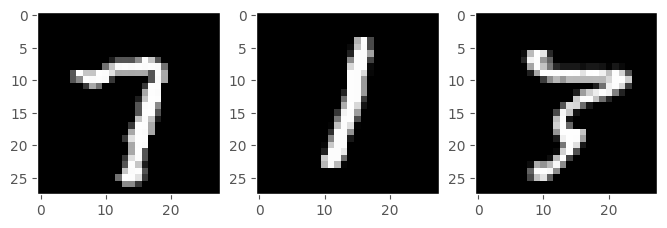

Bag number: 6


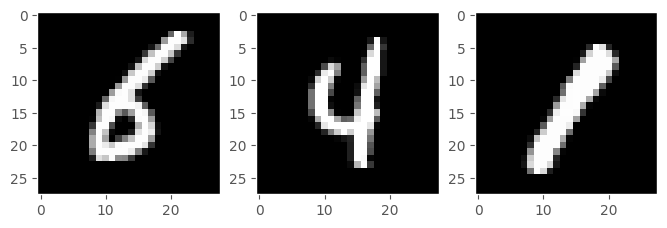

Bag number: 9


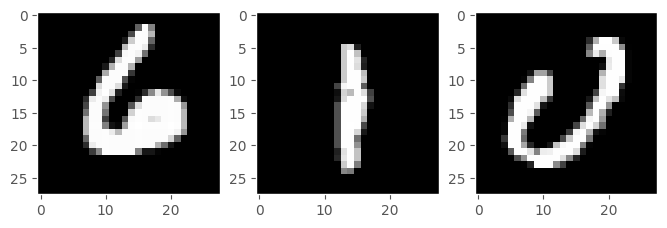

The bag class label is negative
Bag number: 1


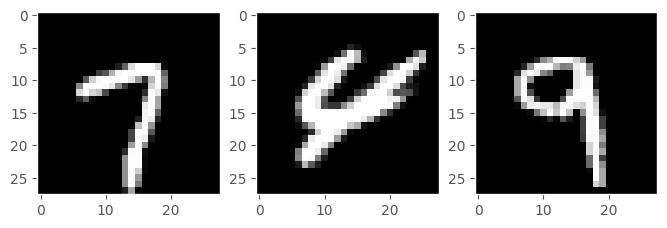

Bag number: 2


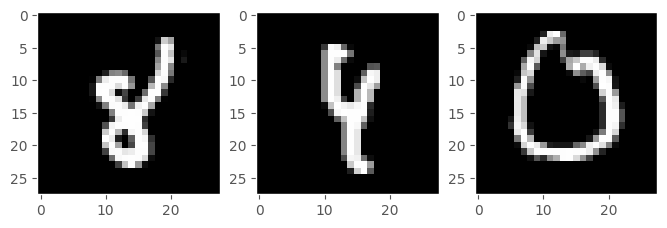

Bag number: 3


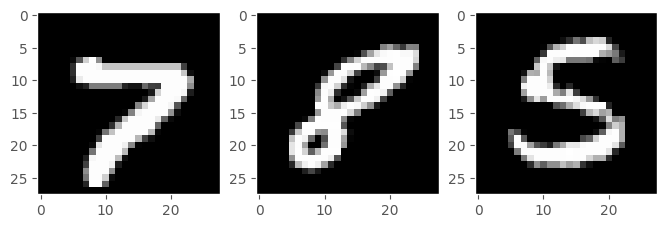

In [5]:
def plot(data, labels, bag_class, predictions=None, attention_weights=None):
    """
    Utility for plotting bags and attention weights.

    Args:
        data: Input data that contains the bags of instances.
        labels: The associated bag labels of the input data.
        bag_class: String name of the desired bag class.
            The options are: "positive" or "negative".
        predictions: Class labels model predictions.
            If not provided, ground truth labels will be used.
        attention_weights: Attention weights for each instance within the input data.
            If not provided, the values won't be displayed.
    """
    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":
        if predictions is not None:
            # Use predicted positive bags
            labels = np.where(predictions.argmax(1) == 1)[0]
        else:
            # Use ground truth positive bags
            labels = np.where(labels == 1)[0]
    elif bag_class == "negative":
        if predictions is not None:
            # Use predicted negative bags
            labels = np.where(predictions.argmax(1) == 0)[0]
        else:
            # Use ground truth negative bags
            labels = np.where(labels == 0)[0]
    else:
        print(f"There is no class {bag_class}")
        return

    # Select bags to plot
    bags = np.array(data)[labels[:PLOT_SIZE]]
    print(f"The bag class label is {bag_class}")

    # Plot each bag
    for i in range(min(PLOT_SIZE, len(labels))):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[i][j]  # Get the instance
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                # Extract the scalar value from the numpy array and format it
                attention_value = attention_weights[labels[i], j, 0]  # Shape: (300, 3, 1)
                plt.title(f"Attention: {attention_value:.2f}")
            plt.imshow(image, cmap="gray")
        plt.show()

# Example usage
# Assuming val_data, val_labels, and model predictions are available

# Plot some validation data bags per class
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

# If you have model predictions and attention weights, you can use them like this:
# predictions = model(val_data)  # Example model predictions
# attention_weights = ...  # Example attention weights
# plot(val_data, val_labels, "positive", predictions=predictions, attention_weights=attention_weights)

## Create model

First we will create some embeddings per instance, invoke the attention operator and then
use the softmax function to output the class probabilities.

In [6]:
class MILModel(nn.Module):
    """Attention-based Deep MIL model.

    Args:
        instance_shape: Shape of each instance in the bag (e.g., (28, 28) for MNIST).
        hidden_dim: Dimension of the hidden layers.
        weight_params_dim: Dimension of the weight matrix in the attention layer.
        num_classes: Number of output classes.
        use_gated: Boolean, whether or not to use the gated mechanism in the attention layer.
    """

    def __init__(self, instance_shape, hidden_dim=128, weight_params_dim=256, num_classes=2, use_gated=True):
        super(MILModel, self).__init__()
        self.instance_shape = instance_shape
        self.hidden_dim = hidden_dim
        self.weight_params_dim = weight_params_dim
        self.num_classes = num_classes
        self.use_gated = use_gated

        # Flatten layer
        self.flatten = nn.Flatten()

        # Shared dense layers for feature extraction
        self.shared_dense_1 = nn.Linear(instance_shape[0] * instance_shape[1], hidden_dim)
        self.shared_dense_2 = nn.Linear(hidden_dim, hidden_dim // 2)

        # Attention layer
        self.attention_layer = MILAttentionLayer(hidden_dim // 2, weight_params_dim, use_gated)

        # Classification layer
        self.classifier = nn.Linear((hidden_dim // 2) * BAG_SIZE, num_classes)

    def forward(self, bags):
        """
        Args:
            bags: Tensor of shape (batch_size, bag_size, *instance_shape).

        Returns:
            logits: Tensor of shape (batch_size, num_classes).
            attention_scores: Tensor of shape (batch_size, bag_size, 1).
        """
        batch_size, bag_size, *instance_dims = bags.shape

        # Flatten the instance dimensions
        bags = bags.view(batch_size * bag_size, -1)  # (batch_size * bag_size, instance_shape[0] * instance_shape[1])

        # Extract features for each instance
        embeddings = F.relu(self.shared_dense_1(bags))  # (batch_size * bag_size, hidden_dim)
        embeddings = F.relu(self.shared_dense_2(embeddings))  # (batch_size * bag_size, hidden_dim // 2)

        # Reshape embeddings to (batch_size, bag_size, hidden_dim // 2)
        embeddings = embeddings.view(batch_size, bag_size, -1)

        # Compute attention scores
        attention_scores = self.attention_layer(embeddings)  # (batch_size, bag_size, 1)

        # Multiply attention scores with embeddings
        weighted_embeddings = embeddings * attention_scores  # (batch_size, bag_size, hidden_dim // 2)

        # Concatenate weighted embeddings
        concat_embeddings = weighted_embeddings.view(batch_size, -1)  # (batch_size, bag_size * hidden_dim // 2)

        # Classify
        logits = self.classifier(concat_embeddings)  # (batch_size, num_classes)

        return logits, attention_scores

## Class weights

Since this kind of problem could simply turn into imbalanced data classification problem,
class weighting should be considered.

Let's say there are 1000 bags. There often could be cases were ~90 % of the bags do not
contain any positive label and ~10 % do.
Such data can be referred to as **Imbalanced data**.

Using class weights, the model will tend to give a higher weight to the rare class.

In [7]:
def compute_class_weights(labels):
    """
    Compute class weights for imbalanced data.

    Args:
        labels: Array of bag labels (0 for negative, 1 for positive).

    Returns:
        class_weights: Dictionary with class weights for negative (0) and positive (1) classes.
    """
    # Count number of positive and negative bags
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Compute class weights
    class_weights = {
        0: (1 / negative_count) * (total_count / 2),  # Weight for negative class
        1: (1 / positive_count) * (total_count / 2),  # Weight for positive class
    }

    return class_weights

## Build and train model

The model is built and trained in this section.

In [8]:
def train(train_data, train_labels, val_data, val_labels, model, num_epochs=20, patience=10):
    """
    Train the MIL model.

    Args:
        train_data: Training data (bags of instances).
        train_labels: Training labels.
        val_data: Validation data.
        val_labels: Validation labels.
        model: The MIL model to train.
        num_epochs: Number of training epochs.
        patience: Number of epochs to wait for improvement before early stopping.

    Returns:
        model: The trained model.
    """
    # Compute class weights
    class_weights = compute_class_weights(train_labels)
    class_weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32)

    # Define loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader for training and validation
    train_dataset = MILDataset(train_data, train_labels)
    val_dataset = MILDataset(val_data, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # Initialize variables for early stopping
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    # Path to save the best model weights
    file_path = "best_model.pth"

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training phase
        for bags, labels in train_loader:
            # Squeeze the labels tensor to remove extra dimensions
            labels = labels.squeeze(0)  # Only remove the first dimension if its size is 1

            # Forward pass
            logits, _ = model(bags)
            loss = criterion(logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for bags, labels in val_loader:
                # Squeeze the labels tensor to remove extra dimensions
                labels = labels.squeeze(0)  # Only remove the first dimension if its size is 1

                logits, _ = model(bags)
                loss = criterion(logits, labels)
                val_loss += loss.item()

        # Average losses
        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the best model weights
            torch.save(model.state_dict(), file_path)
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Load the best model weights
    model.load_state_dict(torch.load(file_path))

    return model

# Define the instance shape (e.g., (28, 28) for MNIST)
instance_shape = train_data[0][0].shape

# Build the model(s)
models = [MILModel(instance_shape, hidden_dim=128, weight_params_dim=256, num_classes=2, use_gated=True)
          for _ in range(ENSEMBLE_AVG_COUNT)]

# Show single model architecture
print(models[0])

# Train the model(s)
trained_models = []
for model in tqdm(models):
    trained_model = train(train_data, train_labels, val_data, val_labels, model)
    trained_models.append(trained_model)

MILModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (shared_dense_1): Linear(in_features=784, out_features=128, bias=True)
  (shared_dense_2): Linear(in_features=128, out_features=64, bias=True)
  (attention_layer): MILAttentionLayer(
    (v): Linear(in_features=64, out_features=256, bias=True)
    (w): Linear(in_features=256, out_features=1, bias=True)
    (u): Linear(in_features=64, out_features=256, bias=True)
  )
  (classifier): Linear(in_features=192, out_features=2, bias=True)
)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.2017, Val Loss: 0.0859
Epoch 2/20, Train Loss: 0.1027, Val Loss: 0.0607
Epoch 3/20, Train Loss: 0.0812, Val Loss: 0.0640
Epoch 4/20, Train Loss: 0.0636, Val Loss: 0.0490
Epoch 5/20, Train Loss: 0.0520, Val Loss: 0.0256
Epoch 6/20, Train Loss: 0.0496, Val Loss: 0.0282
Epoch 7/20, Train Loss: 0.0111, Val Loss: 0.0558
Epoch 8/20, Train Loss: 0.0053, Val Loss: 0.0337
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.2827
Epoch 10/20, Train Loss: 0.0543, Val Loss: 0.0165
Epoch 11/20, Train Loss: 0.0033, Val Loss: 0.0108
Epoch 12/20, Train Loss: 0.0002, Val Loss: 0.0190
Epoch 13/20, Train Loss: 0.0003, Val Loss: 0.0171
Epoch 14/20, Train Loss: 0.0003, Val Loss: 0.1142
Epoch 15/20, Train Loss: 0.0451, Val Loss: 0.0486
Epoch 16/20, Train Loss: 0.0129, Val Loss: 0.0874
Epoch 17/20, Train Loss: 0.0104, Val Loss: 0.0396
Epoch 18/20, Train Loss: 0.0001, Val Loss: 0.0431
Epoch 19/20, Train Loss: 0.0000, Val Loss: 0.0435


<ipython-input-8-9587cf34fca5>:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))
100%|██████████| 1/1 [01:16<00:00, 76.08s/it]

Epoch 20/20, Train Loss: 0.0000, Val Loss: 0.0446


## Model evaluation

The models are now ready for evaluation.
With each model we also create an associated intermediate model to get the
weights from the attention layer.

We will compute a prediction for each of our `ENSEMBLE_AVG_COUNT` models, and
average them together for our final prediction.

The average loss and accuracy are 0.01 and 99.67 % resp.
The bag class label is positive
Bag number: 0


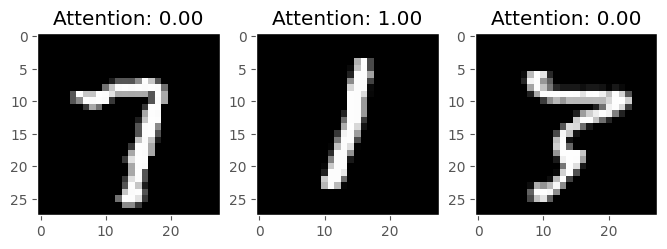

Bag number: 6


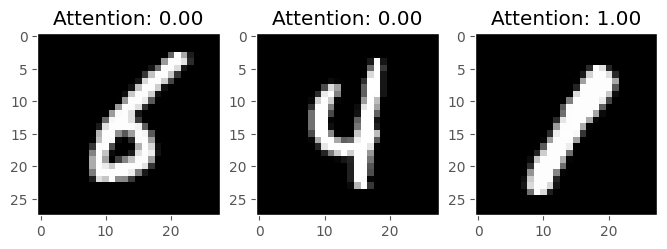

Bag number: 9


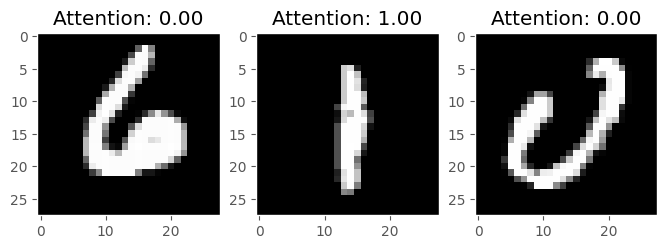

The bag class label is negative
Bag number: 1


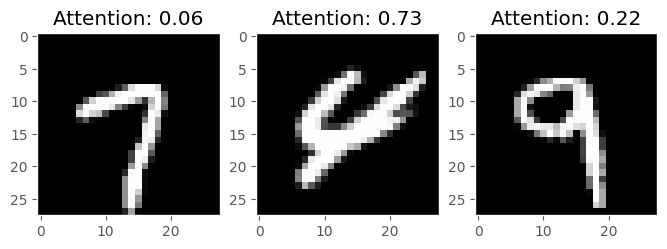

Bag number: 2


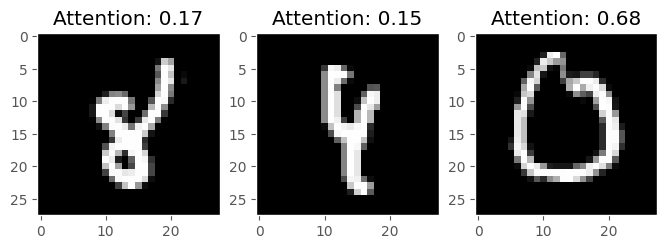

Bag number: 3


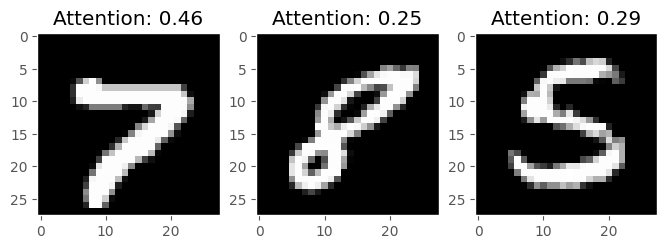

In [9]:
def predict(data, labels, trained_models):
    """
    Evaluate the trained models and compute predictions and attention weights.

    Args:
        data: Input data (bags of instances).
        labels: Ground truth labels.
        trained_models: List of trained models.

    Returns:
        avg_predictions: Average predictions across models.
        avg_attention_weights: Average attention weights across models.
    """
    # Collect info per model
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:
        model.eval()  # Set model to evaluation mode
        predictions = []
        attention_weights = []
        total_loss = 0.0
        total_correct = 0

        with torch.no_grad():
            for bags, labels_batch in DataLoader(MILDataset(data, labels), batch_size=1, shuffle=False):
                # Forward pass
                logits, attn_weights = model(bags)

                # Compute predictions
                preds = torch.softmax(logits, dim=1)
                predictions.append(preds.numpy())

                # Collect attention weights
                attention_weights.append(attn_weights.numpy())

                # Compute loss and accuracy
                loss = nn.CrossEntropyLoss()(logits, labels_batch.squeeze(0))
                total_loss += loss.item()
                total_correct += (preds.argmax(dim=1) == labels_batch.squeeze(0)).sum().item()

        # Store results for this model
        models_predictions.append(np.concatenate(predictions, axis=0))
        models_attention_weights.append(np.concatenate(attention_weights, axis=0))
        models_losses.append(total_loss / len(data))
        models_accuracies.append(total_correct / len(data))

    # Compute average loss and accuracy
    avg_loss = np.mean(models_losses)
    avg_accuracy = np.mean(models_accuracies)
    print(
        f"The average loss and accuracy are {avg_loss:.2f}"
        f" and {100 * avg_accuracy:.2f} % resp."
    )

    # Compute average predictions and attention weights
    avg_predictions = np.mean(models_predictions, axis=0)
    avg_attention_weights = np.mean(models_attention_weights, axis=0)

    return avg_predictions, avg_attention_weights

# Evaluate and predict classes and attention scores on validation data
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

# Plot some results from our validation data
plot(
    val_data,
    val_labels,
    "positive",
    predictions=class_predictions,
    attention_weights=attention_params,
)
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)

## Conclusion

From the above plot, you can notice that the weights always sum to 1. In a
positively predict bag, the instance which resulted in the positive labeling will have
a substantially higher attention score than the rest of the bag. However, in a negatively
predicted bag, there are two cases:

* All instances will have approximately similar scores.
* An instance will have relatively higher score (but not as high as of a positive instance).
This is because the feature space of this instance is close to that of the positive instance.

## Remarks

- If the model is overfit, the weights will be equally distributed for all bags. Hence,
the regularization techniques are necessary.
- In the paper, the bag sizes can differ from one bag to another. For simplicity, the
bag sizes are fixed here.
- In order not to rely on the random initial weights of a single model, averaging ensemble
methods should be considered.